In [1]:
import numpy as np
import pandas as pd
from gymnasium import Env, spaces
from stable_baselines3 import PPO,DQN, A2C
from stable_baselines3.common.env_checker import check_env
from sklearn.preprocessing import MinMaxScaler
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt

In [2]:
class DDoSDetectionEnv(Env):
    def __init__(self, data):
        super(DDoSDetectionEnv, self).__init__()
        
        # Print original data shape for debugging
        print(f"Original data shape: {data.shape}")
        
        # Normalize the data to [0, 1] range
        scaler = MinMaxScaler()
        features = data.drop(columns=['Label'])
        self.data = pd.DataFrame(features, columns=features.columns)
        self.labels = data['Label'].values
        
        # Print normalized data shape for debugging
        print(f"Normalized data shape: {self.data.shape}")
        print(f"Labels shape: {self.labels.shape}")
        
        # Define action and observation space after normalizing the data
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.data.shape[1],), dtype=np.float32)
        
        self.current_step = 0
        
    def reset(self, seed=None):
        # Set the seed for reproducibility
        if seed is not None:
            np.random.seed(seed)
        
        self.current_step = 0
        obs = self.data.iloc[self.current_step].values.astype(np.float32)
        info = {}  # Additional information you might want to include
        
        return obs, info
    
    def step(self, action):
        # Get current state
        state = self.data.iloc[self.current_step].values.astype(np.float32)
        
        # Get reward
        reward = 1 if action == self.labels[self.current_step] else -1
        
        # Check if done
        self.current_step += 1
        done = self.current_step >= len(self.data)
        
        # Get next state
        next_state = self.data.iloc[self.current_step].values.astype(np.float32) if not done else state
        
        terminated = done
        truncated = False  # You can set truncation condition if any
        info = {}  # Additional information you might want to include
        
        return next_state, reward, terminated, truncated, info
    
    def render(self):
        pass


In [ ]:
# Load your dataset
df = pd.read_csv('./datasets/scaled_network_traffic_cleaned.csv')
df.drop(columns=['Flow ID'], inplace=True)

# Create the custom environment
env = DDoSDetectionEnv(df)

# Check if the environment follows Gym's API
check_env(env, warn=True)


Original data shape: (225745, 84)
Normalized data shape: (225745, 83)
Labels shape: (225745,)


In [5]:







# Define and train the PPO model
model = PPO('MlpPolicy', env, verbose=1,device="cuda")
model.learn(total_timesteps=100000)


# Test the model


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 1118 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 805         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.020586919 |
|    clip_fraction        | 0.517       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.674      |
|    explained_variance   | -0.0114     |
|    learning_rate        | 0.0003      |
|    loss                 | 3.28        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0615     |
|    value_loss         

In [6]:
ppo_rw=[]
episodes = 10
for episode in range(episodes):
    obs, info = env.reset(seed=42)
    done = False
    total_reward = 0
    while not done:
        action, _states = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
        ppo_rw.append(total_reward)
    
    print(f"Episode {episode + 1}: Total Reward: {total_reward}")

print("Testing Complete")


Episode 1: Total Reward: 121293
Episode 2: Total Reward: 121225
Episode 3: Total Reward: 121297
Episode 4: Total Reward: 121059
Episode 5: Total Reward: 121339
Episode 6: Total Reward: 121237
Episode 7: Total Reward: 121417
Episode 8: Total Reward: 121273
Episode 9: Total Reward: 121149
Episode 10: Total Reward: 120827
Testing Complete


In [10]:

from stable_baselines3.common.monitor import Monitor

# Create environment
env = DDoSDetectionEnv(df)
env = Monitor(env)


# Check environment
check_env(env, warn=True)

# Train A2C Model
a2c_model = A2C('MlpPolicy', env, verbose=1)
a2c_model.learn(total_timesteps=100000)

# Evaluate the model


# Test the trained model



Original data shape: (225745, 84)
Normalized data shape: (225745, 83)
Labels shape: (225745,)
Using cpu device
Wrapping the env in a DummyVecEnv.
------------------------------------
| time/                 |          |
|    fps                | 534      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.0698  |
|    explained_variance | 0.0891   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.0338   |
|    value_loss         | 7.41     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 526      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.0249  |
|    explained_variance | -0.00156 |
|  

-------------------------------------
| time/                 |           |
|    fps                | 649       |
|    iterations         | 1700      |
|    time_elapsed       | 13        |
|    total_timesteps    | 8500      |
| train/                |           |
|    entropy_loss       | -0.000206 |
|    explained_variance | 0.000879  |
|    learning_rate      | 0.0007    |
|    n_updates          | 1699      |
|    policy_loss        | 5.68e-06  |
|    value_loss         | 0.136     |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 653       |
|    iterations         | 1800      |
|    time_elapsed       | 13        |
|    total_timesteps    | 9000      |
| train/                |           |
|    entropy_loss       | -0.000136 |
|    explained_variance | 0.000116  |
|    learning_rate      | 0.0007    |
|    n_updates          | 1799      |
|    policy_loss        | 2.14e-06  |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 684       |
|    iterations         | 3300      |
|    time_elapsed       | 24        |
|    total_timesteps    | 16500     |
| train/                |           |
|    entropy_loss       | -9e-05    |
|    explained_variance | 0.00381   |
|    learning_rate      | 0.0007    |
|    n_updates          | 3299      |
|    policy_loss        | -8.39e-09 |
|    value_loss         | 1.76e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 685       |
|    iterations         | 3400      |
|    time_elapsed       | 24        |
|    total_timesteps    | 17000     |
| train/                |           |
|    entropy_loss       | -0.000106 |
|    explained_variance | -0.0805   |
|    learning_rate      | 0.0007    |
|    n_updates          | 3399      |
|    policy_loss        | -8.68e-09 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 685       |
|    iterations         | 4900      |
|    time_elapsed       | 35        |
|    total_timesteps    | 24500     |
| train/                |           |
|    entropy_loss       | -0.00239  |
|    explained_variance | -2.01e-05 |
|    learning_rate      | 0.0007    |
|    n_updates          | 4899      |
|    policy_loss        | 5.56e-05  |
|    value_loss         | 0.0565    |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 686      |
|    iterations         | 5000     |
|    time_elapsed       | 36       |
|    total_timesteps    | 25000    |
| train/                |          |
|    entropy_loss       | -0.00208 |
|    explained_variance | -3.7e-06 |
|    learning_rate      | 0.0007   |
|    n_updates          | 4999     |
|    policy_loss        | 1.78e-05 |
|    value_loss         

-------------------------------------
| time/                 |           |
|    fps                | 699       |
|    iterations         | 6500      |
|    time_elapsed       | 46        |
|    total_timesteps    | 32500     |
| train/                |           |
|    entropy_loss       | -0.000323 |
|    explained_variance | 1.79e-06  |
|    learning_rate      | 0.0007    |
|    n_updates          | 6499      |
|    policy_loss        | -0.000149 |
|    value_loss         | 34.2      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 700       |
|    iterations         | 6600      |
|    time_elapsed       | 47        |
|    total_timesteps    | 33000     |
| train/                |           |
|    entropy_loss       | -0.000569 |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 6599      |
|    policy_loss        | -0.000271 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 709       |
|    iterations         | 8100      |
|    time_elapsed       | 57        |
|    total_timesteps    | 40500     |
| train/                |           |
|    entropy_loss       | -6.95e-05 |
|    explained_variance | -2.26e-06 |
|    learning_rate      | 0.0007    |
|    n_updates          | 8099      |
|    policy_loss        | -2.95e-05 |
|    value_loss         | 38.5      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 710       |
|    iterations         | 8200      |
|    time_elapsed       | 57        |
|    total_timesteps    | 41000     |
| train/                |           |
|    entropy_loss       | -9.5e-05  |
|    explained_variance | -1.79e-06 |
|    learning_rate      | 0.0007    |
|    n_updates          | 8199      |
|    policy_loss        | -3.97e-05 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 714       |
|    iterations         | 9700      |
|    time_elapsed       | 67        |
|    total_timesteps    | 48500     |
| train/                |           |
|    entropy_loss       | -0.00432  |
|    explained_variance | -9.66e-06 |
|    learning_rate      | 0.0007    |
|    n_updates          | 9699      |
|    policy_loss        | 0.000239  |
|    value_loss         | 0.275     |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 713      |
|    iterations         | 9800     |
|    time_elapsed       | 68       |
|    total_timesteps    | 49000    |
| train/                |          |
|    entropy_loss       | -0.003   |
|    explained_variance | 2.75e-05 |
|    learning_rate      | 0.0007   |
|    n_updates          | 9799     |
|    policy_loss        | 0.000113 |
|    value_loss         

------------------------------------
| time/                 |          |
|    fps                | 706      |
|    iterations         | 11300    |
|    time_elapsed       | 79       |
|    total_timesteps    | 56500    |
| train/                |          |
|    entropy_loss       | -0.0174  |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 11299    |
|    policy_loss        | 0.00242  |
|    value_loss         | 1.16     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 701      |
|    iterations         | 11400    |
|    time_elapsed       | 81       |
|    total_timesteps    | 57000    |
| train/                |          |
|    entropy_loss       | -0.0127  |
|    explained_variance | 5.54e-06 |
|    learning_rate      | 0.0007   |
|    n_updates          | 11399    |
|    policy_loss        | 0.00145  |
|    value_loss         | 0.857    |
-

------------------------------------
| time/                 |          |
|    fps                | 682      |
|    iterations         | 12900    |
|    time_elapsed       | 94       |
|    total_timesteps    | 64500    |
| train/                |          |
|    entropy_loss       | -0.00802 |
|    explained_variance | -0.0113  |
|    learning_rate      | 0.0007   |
|    n_updates          | 12899    |
|    policy_loss        | 2.52e-06 |
|    value_loss         | 7.52e-06 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 682      |
|    iterations         | 13000    |
|    time_elapsed       | 95       |
|    total_timesteps    | 65000    |
| train/                |          |
|    entropy_loss       | -0.00799 |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 12999    |
|    policy_loss        | 2.29e-08 |
|    value_loss         | 9.9e-10  |
-

------------------------------------
| time/                 |          |
|    fps                | 685      |
|    iterations         | 14500    |
|    time_elapsed       | 105      |
|    total_timesteps    | 72500    |
| train/                |          |
|    entropy_loss       | -0.054   |
|    explained_variance | 0.000116 |
|    learning_rate      | 0.0007   |
|    n_updates          | 14499    |
|    policy_loss        | 0.00383  |
|    value_loss         | 0.194    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 686      |
|    iterations         | 14600    |
|    time_elapsed       | 106      |
|    total_timesteps    | 73000    |
| train/                |          |
|    entropy_loss       | -0.0122  |
|    explained_variance | 5.96e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 14599    |
|    policy_loss        | 0.000449 |
|    value_loss         | 0.0901   |
-

-------------------------------------
| time/                 |           |
|    fps                | 690       |
|    iterations         | 16100     |
|    time_elapsed       | 116       |
|    total_timesteps    | 80500     |
| train/                |           |
|    entropy_loss       | -0.0213   |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 16099     |
|    policy_loss        | -0.018    |
|    value_loss         | 37.3      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 690      |
|    iterations         | 16200    |
|    time_elapsed       | 117      |
|    total_timesteps    | 81000    |
| train/                |          |
|    entropy_loss       | -0.0282  |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 16199    |
|    policy_loss        | -0.0249  |
|    value_loss         

------------------------------------
| time/                 |          |
|    fps                | 693      |
|    iterations         | 17700    |
|    time_elapsed       | 127      |
|    total_timesteps    | 88500    |
| train/                |          |
|    entropy_loss       | -0.414   |
|    explained_variance | 1.73e-06 |
|    learning_rate      | 0.0007   |
|    n_updates          | 17699    |
|    policy_loss        | -0.904   |
|    value_loss         | 40.6     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 693       |
|    iterations         | 17800     |
|    time_elapsed       | 128       |
|    total_timesteps    | 89000     |
| train/                |           |
|    entropy_loss       | -0.0604   |
|    explained_variance | -0.000285 |
|    learning_rate      | 0.0007    |
|    n_updates          | 17799     |
|    policy_loss        | 0.000727  |
|    value_loss         | 

------------------------------------
| time/                 |          |
|    fps                | 697      |
|    iterations         | 19300    |
|    time_elapsed       | 138      |
|    total_timesteps    | 96500    |
| train/                |          |
|    entropy_loss       | -0.186   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 19299    |
|    policy_loss        | -0.268   |
|    value_loss         | 40.5     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 697      |
|    iterations         | 19400    |
|    time_elapsed       | 139      |
|    total_timesteps    | 97000    |
| train/                |          |
|    entropy_loss       | -0.274   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 19399    |
|    policy_loss        | -0.454   |
|    value_loss         | 38.3     |
-

In [11]:
a2c_reward=[]
episodes = 10
for episode in range(episodes):
    obs, info = env.reset(seed=42)
    done = False
    total_reward = 0
    
    while not done:
        action, _states = a2c_model.predict(obs)  # Use trained model
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
    
    print(f"Episode {episode + 1}: Total Reward: {total_reward}")

print("Testing Complete")

Episode 1: Total Reward: 31369
Episode 2: Total Reward: 31217
Episode 3: Total Reward: 31221
Episode 4: Total Reward: 31309
Episode 5: Total Reward: 31241
Episode 6: Total Reward: 31283
Episode 7: Total Reward: 31285
Episode 8: Total Reward: 31227
Episode 9: Total Reward: 31293
Episode 10: Total Reward: 31451
Testing Complete


In [7]:


from stable_baselines3.common.monitor import Monitor
# Create the custom environment
env = DDoSDetectionEnv(df)
env = Monitor(env)

# Check if the environment follows Gym's API
check_env(env, warn=True)


dqn_model = DQN('MlpPolicy', env, verbose=1)
dqn_model.learn(total_timesteps=10000)






Original data shape: (225745, 84)
Normalized data shape: (225745, 83)
Labels shape: (225745,)
Using cpu device
Wrapping the env in a DummyVecEnv.


In [8]:
episodes = 10
for episode in range(episodes):
    obs, info = env.reset(seed=42)
    done = False
    total_reward = 0
    while not done:
        action, _states = dqn_model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
    
    print(f"Episode {episode + 1}: Total Reward: {total_reward}")

Episode 1: Total Reward: -28759
Episode 2: Total Reward: -28781
Episode 3: Total Reward: -28913
Episode 4: Total Reward: -28729
Episode 5: Total Reward: -28727
Episode 6: Total Reward: -28649
Episode 7: Total Reward: -28903
Episode 8: Total Reward: -28835
Episode 9: Total Reward: -28591
Episode 10: Total Reward: -28585


Using cpu device
Wrapping the env in a DummyVecEnv.


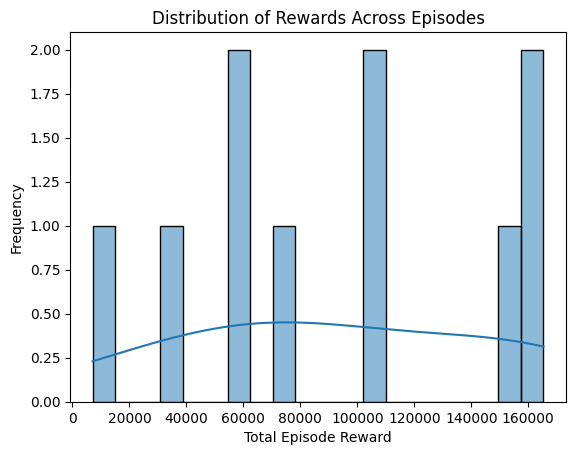

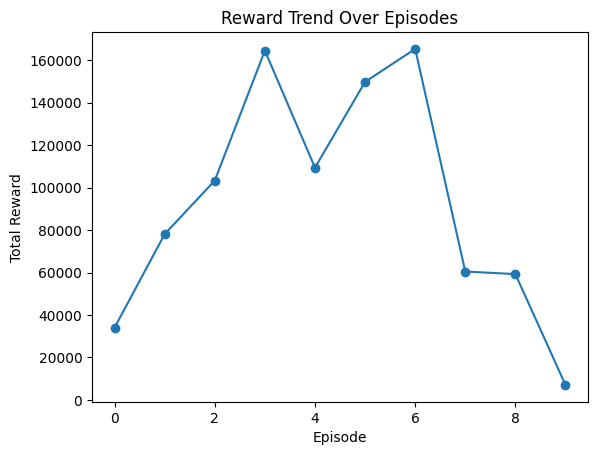

In [3]:
import gymnasium as gym
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import PPO,DQN, A2C
from gymnasium import spaces
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy

# Load dataset
df = pd.read_csv("scaled_network_traffic_cleaned.csv")  # Ensure this file exists
feature_columns = df.columns[-3:-2]   # All columns except the label
label_column = "Label"  # Target column

df[feature_columns] = df[feature_columns].apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)
df[feature_columns] = (df[feature_columns] - df[feature_columns].min()) / (df[feature_columns].max() - df[feature_columns].min())

data = df[feature_columns].values.astype(np.float32)
labels = df[label_column].map(lambda x: 1 if x == "DDoS" else 0).values

# Create a Custom Gymnasium Environment for DDoS Attack Detection
class DDoSEnv(gym.Env):
    def __init__(self, data, labels):
        super(DDoSEnv, self).__init__()
        self.data = data
        self.labels = labels
        self.num_samples = len(data)
        self.num_features = data.shape[1]
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.num_features,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)  # 0: Normal, 1: DDoS Attack
        self.current_index = 0

    def step(self, action):
        label = self.labels[self.current_index]
        reward = 1 if action == label else -1
        self.current_index = (self.current_index + 1) % self.num_samples
        state = self.data[self.current_index].astype(np.float32)
        done = self.current_index == 0
        return state, reward, done, False, {}

    def reset(self, seed=None, options=None):
        self.current_index = random.randint(0, self.num_samples - 1)
        return self.data[self.current_index].astype(np.float32), {}

    def render(self, mode='human'):
        pass

# Initialize and Check Environment
env = DDoSEnv(data, labels)
check_env(env)
env=Monitor(env)


# Train an RL Model (DQN) on GPU
model = DQN("MlpPolicy", env, verbose=1, device="cuda:0")  # Use "cuda" for GPU
model.learn(total_timesteps=100000)

# Evaluate the Model
# mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
# print(f"Mean Reward: {mean_reward}, Std Reward: {std_reward}")

# Visualization of Model Performance
def evaluate_agent(model, env, episodes=10):
    rewards = []
    for _ in range(episodes):
        obs, _ = env.reset()
        total_reward = 0
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _, _ = env.step(action)
            total_reward += reward
        rewards.append(total_reward)
    return rewards

# Get Rewards Over Multiple Episodes
reward_list = evaluate_agent(model, env, episodes=10)

# Plot Reward Distribution
sns.histplot(reward_list, bins=20, kde=True)
plt.xlabel("Total Episode Reward")
plt.ylabel("Frequency")
plt.title("Distribution of Rewards Across Episodes")
plt.show()

# Plot Reward Trend
plt.plot(reward_list, marker='o')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Reward Trend Over Episodes")
plt.show()


In [4]:
print(reward_list)

[34052, 78116, 103322, 164546, 109416, 149816, 165335, 60502, 59269, 7082]
